In [1]:
%load_ext tensorboard

In [2]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
print('tf.test.is_gpu_available:', tf.test.is_gpu_available())

tf.test.is_gpu_available: True


In [5]:
data_dir = '/kaggle/input/arasl-database-54k-final'
arabic_alphabet = ['ع', 'ال', 'أ', 'ب', 'د', 'ظ', 'ض', 'ف', 'ق', 'غ', 'ه', 'ح', 'ج', 'ك', 'خ', 'لا', 'ل', 'م', 'ن', 'ر', 'ص', 'س', 'ش', 'ط', 'ت', 'ث', 'ذ', 'ة', 'و', 'ئ', 'ي', 'ز']
arabic_alphabet_latin = os.listdir(f'{data_dir}/ArASL_Database_54K_Final')

In [6]:
def load_image(image_path):
    img = image.load_img(image_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

In [7]:
data = pd.read_csv(f'{data_dir}/ArSL_Data_Labels.csv')
data.drop(columns=['#'], inplace=True)
data.columns = ['image', 'class']
data

,image,class
0,AIN (1).JPG,ain
1,AIN (10).JPG,ain
2,AIN (100).jpg,ain
3,AIN (1000).JPG,ain
4,AIN (1001).JPG,ain
...,...,...
54044,ZAY (995).jpg,zay
54045,ZAY (996).jpg,zay
54046,ZAY (997).jpg,zay
54047,ZAY (998).jpg,zay


In [8]:
print(data['class'])

0        ain
1        ain
2        ain
3        ain
4        ain
        ... 
54044    zay
54045    zay
54046    zay
54047    zay
54048    zay
Name: class, Length: 54049, dtype: object


In [9]:
X = []
y = []

for i in range(data.shape[0]):
    img_path = os.path.join(data_dir + '/ArASL_Database_54K_Final/' + data['class'][i], data['image'][i])
    img = load_image(img_path)
    X.append(img)
    y.append(arabic_alphabet_latin.index(data['class'][i]))    
    print(f'Processed images: {i+1}/{data.shape[0]}', end='\r')

print("\n")

X = np.array(X)
X = X.reshape((54049, 64, 64, 3))
y = np.array(y)

print(X.shape, y.shape)

Processed images: 54049/54049

(54049, 64, 64, 3) (54049,)


In [10]:
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
base_model.trainable = False
print("Number of layers in the base model: ", len(base_model.layers))
# base_model.summary()
for layer in base_model.layers[811:]:
    layer.trainable = True

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Number of layers in the base model:  814


In [11]:
# model = tf.keras.models.Sequential([
#     base_model,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(2560, activation='relu'),
#     tf.keras.layers.Dense(32, activation='softmax')
# ])

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2560, activation='relu'),
    tf.keras.layers.Dense(32, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy', 'sparse_categorical_crossentropy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ ?                      │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 1,643,520 (6.27 MB)

 Non-trainable params: 62,454,167 (238.24 MB)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

(43239, 64, 64, 3)
(10810, 64, 64, 3)
(43239,)
(10810,)
{0: 1376, 1: 1406, 2: 1434, 3: 1335, 4: 1341, 5: 1459, 6: 1344, 7: 1453, 8: 1025, 9: 1487, 10: 1379, 11: 1291, 12: 1208, 13: 1101, 14: 1210, 15: 1102, 16: 1369, 17: 1408, 18: 1062, 19: 1601, 20: 1407, 21: 1688, 22: 1509, 23: 1262, 24: 1331, 25: 1575, 26: 1288, 27: 1235, 28: 1418, 29: 1409, 30: 1291, 31: 1435}
{0: 329, 1: 359, 2: 404, 3: 324, 4: 329, 5: 357, 6: 294, 7: 313, 8: 268, 9: 345, 10: 344, 11: 343, 12: 299, 13: 273, 14: 316, 15: 269, 16: 353, 17: 383, 18: 281, 19: 376, 20: 384, 21: 426, 22: 386, 23: 320, 24: 341, 25: 380, 26: 319, 27: 317, 28: 328, 29: 410, 30: 301, 31: 339}


In [13]:
logdir = "/kaggle/working/logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.003, patience=10)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/kaggle/working/model_checkpoint.keras', save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)

tf.debugging.set_log_device_placement(True)

with tf.device("/device:GPU:0"):
    X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
    y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
    X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
    y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)
    
    history = model.fit(X_train_tensor, y_train_tensor, epochs=100, batch_size=256, validation_data=(X_test_tensor, y_test_tensor), callbacks=[checkpoint_callback, tensorboard_callback])

Epoch 1/100


I0000 00:00:1732632343.996536      96 service.cc:145] XLA service 0x7e8a80001eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732632343.996631      96 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1732632446.746901      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


169/169 ━━━━━━━━━━━━━━━━━━━━ 284s 892ms/step - accuracy: 0.5380 - loss: 1.5516 - sparse_categorical_crossentropy: 1.5516 - val_accuracy: 0.6681 - val_loss: 0.9968 - val_sparse_categorical_crossentropy: 0.9968
Epoch 2/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 28s 167ms/step - accuracy: 0.8291 - loss: 0.5211 - sparse_categorical_crossentropy: 0.5211 - val_accuracy: 0.7892 - val_loss: 0.6302 - val_sparse_categorical_crossentropy: 0.6302
Epoch 3/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 28s 167ms/step - accuracy: 0.8762 - loss: 0.3845 - sparse_categorical_crossentropy: 0.3845 - val_accuracy: 0.8142 - val_loss: 0.5683 - val_sparse_categorical_crossentropy: 0.5683
Epoch 4/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 29s 170ms/step - accuracy: 0.8987 - loss: 0.3096 - sparse_categorical_crossentropy: 0.3096 - val_accuracy: 0.8702 - val_loss: 0.4079 - val_sparse_categorical_crossentropy: 0.4079
Epoch 5/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 28s 167ms/step - accuracy: 0.9134 - loss: 0.2761 - sparse_categorical_crossentropy: 0.2761

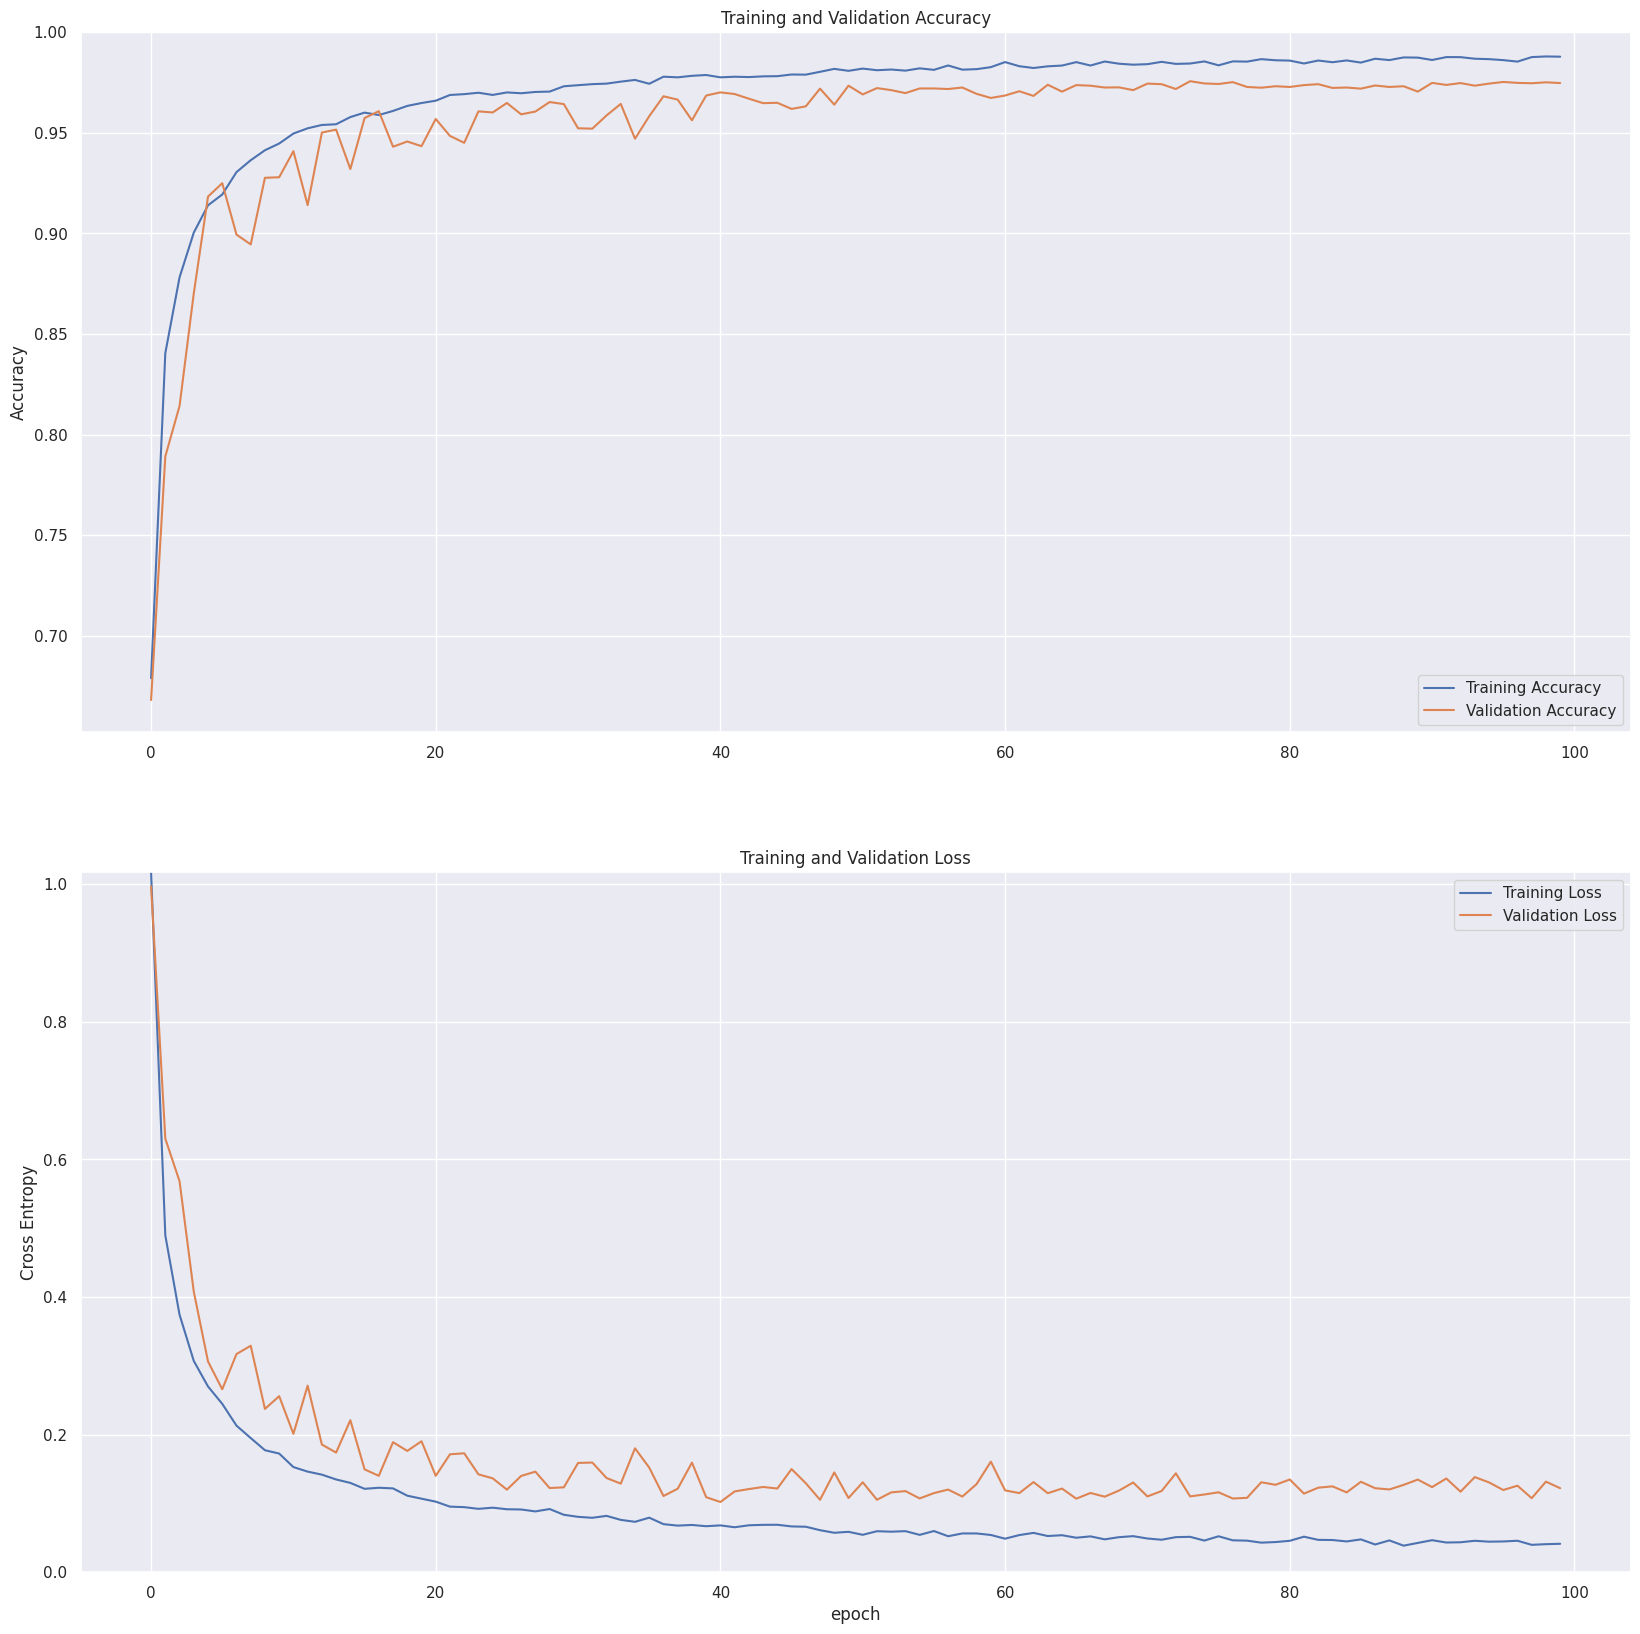

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

sns.set(rc={'figure.figsize':(20, 20)})
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max([max(loss), max(val_loss)])])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('/kaggle/working/vertical_plot.png')
plt.savefig('/kaggle/working/vertical_plot.pdf')
plt.show()

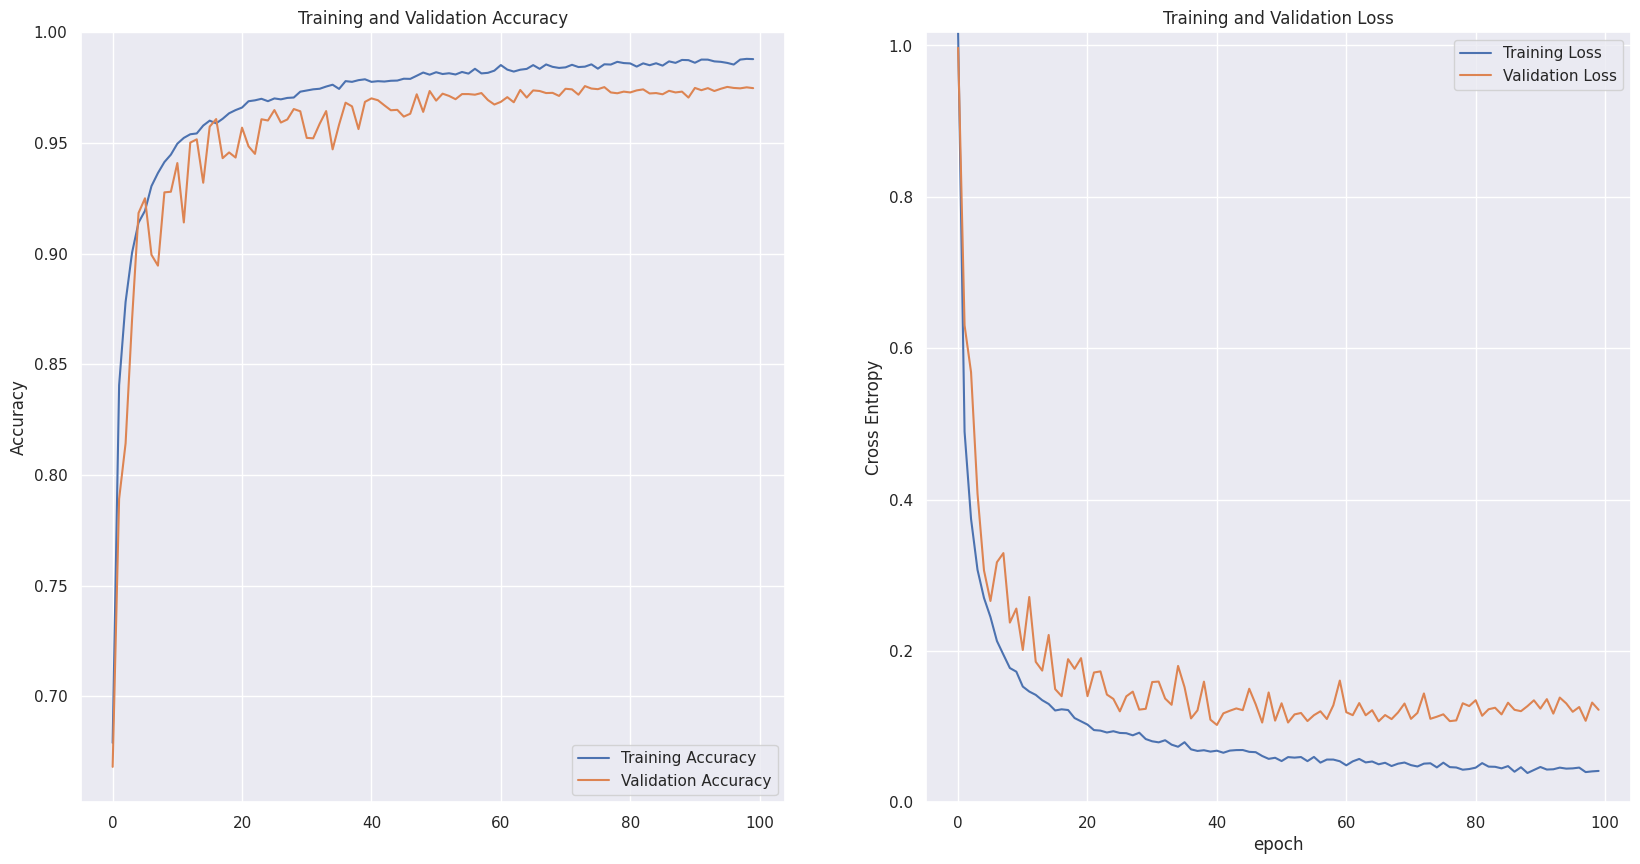

In [27]:
sns.set(rc={'figure.figsize':(20, 10)})
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max([max(loss), max(val_loss)])])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('/kaggle/working/horizontal_plot.png')
plt.savefig('/kaggle/working/horizontal_plot.pdf')
plt.show()

In [ ]:
model.save('/kaggle/working/model.h5')
model.save('/kaggle/working/model.keras')

In [33]:
# del X_train
# del X_test
# del y_train
# del y_test
# del model